# Programming Assingnment2 - Transformer, Naver Movie Review Sentiment Analysis
안녕하세요 **AIKU 학회원 여러분**, 두 번째 과제는 지난 주에 배웠던 NLP 수업, 그 중에서도 Transformer 모델을 직접 구현해보는 과제입니다!

NLP 관련해서는 CS224n 수업이 가장 유명하지만 아무래도 처음 공부하시는 분들이 과제를 풀기에는 많이 어려운 부분이 있어 최대한 쉽게 과제를 구상하려고 노력했습니다!

Transformer 모델을 전체를 다 구현하는 것은 너무 어렵기 때문에 이번에는 Transformer의 Encoder 부분만 구현을 하고 이를 이용해서 감성분석 task를 수행할 예정입니다.

네이버의 영화 리뷰 데이터를 바탕으로 source sentence를 Encoding한 후 Encoding된 결과를 linear classifier에 통과시켜 해당 리뷰가 긍정인지 부정인지를 분류하는 task를 수행하는 모델을 구현해 볼 예정입니다.

![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/transformer-model-architecture.png)

## Part 1. 준비


### 1-1. Pip install & Imports
필요한 패키지를 pip를 이용해서 설치합니다.

In [ ]:
!pip install sentencepiece
!pip install wget

필요한 라이브러리를 import합니다

그리고 device를 GPU로 바꿔줍니다!

다만, 코드를 구현하는 과정에서는 **CPU 사용**을 권장드립니다.

GPU가 가장 많이 필요한 단계는 학습하는 과정인데 구현하는 시간동안 colab의 GPU를 다 써버리면 막상 학습할 때 필요한 GPU 자원을 쓸 수 없게 됩니다. 따라서 코드를 모두 구현하고 train 코드가 잘 돌아가는지 확인한 뒤에 colab 상단 런타임 메뉴에서 런타임 유형을 GPU로 바꾼 뒤에 실행하시는 것을 권장드립니다!

In [2]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import json
import pandas as pd
from IPython.display import display
from tqdm import tqdm, tqdm_notebook, trange
import sentencepiece as spm
import wget

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device: ', device)

using device:  cuda


### 1-2. Google Drive Mount
Colab에서는 컴퓨터에 자원에 접근이 불가능 하므로 Google Drive에 파일을 올려 놓은 후 Google Drive를 mount 에서 로컬 디스크처럼 사용 합니다.


In [3]:
# 지난 과제에서도 했던 과정이기 때문에 똑같이 Google Drive를 Mount해주시면 됩니다.
from google.colab import drive
drive.mount('/content/drive')

# data를 저장할 폴더 입니다. 환경에 맞게 수정 하세요.
data_dir = "/content/drive/My Drive/data"

Mounted at /content/drive


### 1-3. Dataset
이번 과제에서 사용할 데이터셋입니다. 아래 링크에서 다운 받은 뒤 위에서 설정한 data를 저장할 폴더에 저장해주세요!

colab에서 그 데이터를 직접 확인하는 코드는 작성해두지 않았습니다. 다만, 아래 사진을 첨부해드렸습니다. 데이터는 id, document, label로 구성되어 있고 id는 식별자, document는 리뷰 데이터, label은 긍정(1), 부정(0)을 의미합니다. 좀 더 자세하게 데이터가 어떻게 생겼는지 알고 싶으신 분들은 txt 파일을 열어보시면 확인할 수 있습니다!

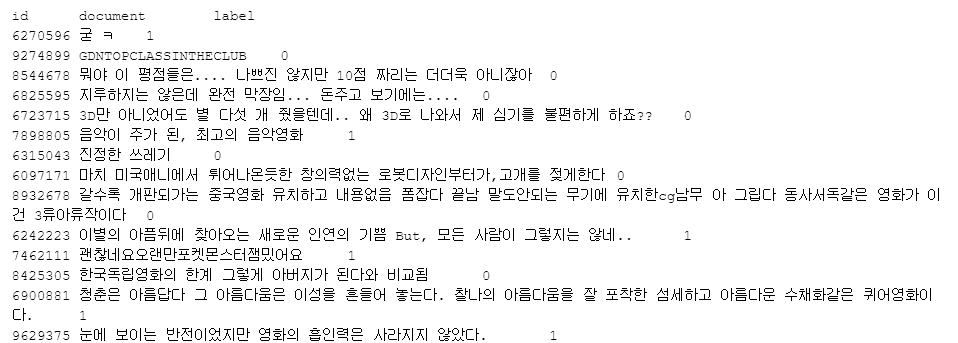


https://drive.google.com/file/d/1Qg_Kd0iyMQ5zYOYGTosVxY00qS6y89lX/view?usp=drive_link


### 1-4. 폴더의 목록을 확인
Google Drive mount가 잘 되었는지 확인하기 위해 data_dir 목록을 확인 합니다.

In [4]:
for f in os.listdir(data_dir):
  print(f)

kowiki.model
kowiki.vocab
ratings_test.txt
ratings_train.txt
ratings_train.json
ratings_test.json


### 1-5. Vocab 및 입력
미리 만들어 놓은 vocab을 로딩 합니다.

로딩된 vocab을 이용해 input을 만듭니다.

In [5]:
# vocab loading
vocab_file = f"{data_dir}/kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

보통 영어를 NLP task를 처리할 때는 단어 기준으로 나누어도 크게 문제가 없지만 한국어는 한 단어가 보다 복잡하게 이루어져 있습니다. vocab을 사용해서 하나의 리뷰 문장을 나누어준 예시입니다.

아래는 한국어 NLP를 어떤식으로 처리하는지에 대해 간단하게 보여주기 위해 추가한 코드입니다.

In [6]:
line = '뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아'
pieces = vocab.encode_as_pieces(line)
ids = vocab.encode_as_ids(line)
print(line)
print(pieces)
print(ids)

뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아
['▁', '뭐', '야', '▁이', '▁평', '점', '들은', '..', '..', '▁나', '쁘', '진', '▁않', '지만', '▁10', '점', '▁', '짜', '리는', '▁더', '더', '욱', '▁아니', '잖', '아']
[3587, 5593, 3766, 8, 229, 3807, 162, 1920, 1920, 57, 5043, 3704, 101, 98, 129, 3807, 3587, 4351, 367, 228, 3840, 4267, 410, 5941, 3621]


## Part2. 영화 분류 데이터셋
이제 본격적으로 트랜스포머 구현을 시작할 예정입니다. 그 전에 다운했던 데이터셋을 학습 과정에서 사용할 수 있도록 로드할 차례입니다.

먼저 아래 'MovieDataSet' 클래스를 봅시다. 여러분이 따로 구현해야할 코드는 없지만 일반적으로 딥러닝에서 DataSet 클래스를 선언할 때 다음과 같이 \_\_len__과
 \_\_getitem__ 을 같이 선언해주게 됩니다. 이 형태에 대해서 한 번 확인해주고 넘어가면 좋을 것 같아요!

In [7]:
""" 영화 분류 데이터셋 """
class MovieDataSet(torch.utils.data.Dataset):
    def __init__(self, vocab, infile):
        self.vocab = vocab
        self.labels = []
        self.sentences = []

        line_cnt = 0
        with open(infile, "r") as f:
            for line in f:
                line_cnt += 1

        with open(infile, "r") as f:
            for i, line in enumerate(tqdm(f, total=line_cnt, desc=f"Loading {infile}", unit=" lines")):
                data = json.loads(line)
                self.labels.append(data["label"])
                self.sentences.append([vocab.piece_to_id(p) for p in data["doc"]])

    def __len__(self):
        assert len(self.labels) == len(self.sentences)
        return len(self.labels)

    def __getitem__(self, item):
        return (torch.tensor(self.labels[item]),
                torch.tensor(self.sentences[item]))

아래 'collate_fn' 함수는 하나의 batch 안에서 문장의 길이가 다 다른 경우에 batch 안에서 가장 긴 길이에 맞춰서 나머지 input을 padding 해주는 역할을 합니다.

In [8]:
def movie_collate_fn(inputs):
    labels, enc_inputs = list(zip(*inputs))

    enc_inputs = torch.nn.utils.rnn.pad_sequence(enc_inputs, batch_first=True, padding_value=0)

    batch = [
        torch.stack(labels, dim=0),
        enc_inputs,
    ]
    return batch

이제 DataLoader를 통해 데이터를 불러올 차례입니다.

In [67]:
""" 데이터 로더 """
batch_size = 128
train_dataset = MovieDataSet(vocab, f"{data_dir}/ratings_train.json")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=movie_collate_fn)
test_dataset = MovieDataSet(vocab, f"{data_dir}/ratings_test.json")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=movie_collate_fn)

Loading /content/drive/My Drive/data/ratings_train.json: 100%|██████████| 149995/149995 [00:04<00:00, 31591.66 lines/s]
Loading /content/drive/My Drive/data/ratings_test.json: 100%|██████████| 49997/49997 [00:01<00:00, 37378.11 lines/s]


In [10]:
# Dataset class에서 __len__을 구현하면 dataset의 크기를 확인할 수 있습니다.
print(len(train_dataset))
# Dataset class에서 __getitem__을 구현하면 dataset을 index를 통해 접근할 수 있습니다.
print(train_dataset[0])

149995
(tensor(0), tensor([  26,  228, 4365, 1920,  132, 4351, 3587, 4351, 3922, 3628, 3857, 3760,
         266, 3678, 3614]))


## Part3. Transformer 구현에 필요한 함수
처음부터 코딩을 하기 보다는 전체 코드의 흐름을 확인하고 각 함수가 왜 필요한지 그리고 서로 다른 class와 함수들이 어떻게 연결되어 있는지를 확인한 뒤에 코딩을 시작하시길 바랍니다!

무턱대고 시작하면 너무 어려울 수 있어요!

### 3-1. Positional Encoding
**해당 함수는 따로 구현할 코드가 없습니다! Positional Encoding이 어떤 식으로 구현되는지 눈으로 확인해봅시다!**



Positional Encoding 값을 구하기 위한 함수 입니다.
Positional Encoding은 입력 문장 단어(토큰)들에 대한 위치정보를 인코딩하는 기술로, Transformer 모델의 입력 임베딩에 이 정보를 추가함으로써 단어의 상대적인 위치를 반영할 수 있습니다. 이렇게 함으로써 모델은 문장의 구조와 순서를 학습할 수 있게 됩니다.

다음 코드는 Transformer에서 사용되는 대표적인 Positional Encoding 방법 중 하나인 Sinusodial Positional Encoding입니다. 이 방법은 고정된 함수로서 주기적인 값을 부여하여 위치정보를 인코딩합니다.

Sinusodial Positional Encoding은 다음과 같은 수식을 사용하여 위치 인코딩 값을 계산합니다.
$PE_{(pos,2i)}​ =sin(\frac {pos}{10000^ {2i/d} model​}​ )$

$PE_{(pos,2i+1)}​ =cos(\frac {pos}{10000^ {2i/d} model​}​ )$

여기서 $PE_{(pos, 2i)}$와 $PE_{(pos, 2i+1)}$는 Positional Encoding 행렬에서 $(pos, 2i)$와 $(pos, 2i+1)$ 위치에 해당하는 값을 의미하며, $pos$는 단어의 위치(position)를 나타내고, $i$는 인코딩 차원의 인덱스를 의미합니다. $d_{\text{model}}$은 임베딩 차원의 크기를 나타냅니다.

이렇게 구해진 Positional Encoding 행렬은 입력 임베딩과 더해져서 최종 입력으로 들어가게 되며, 모델은 이를 활용하여 문장의 구조와 순서를 이해하고 학습합니다.

In [11]:
def PosEncoding(t_len, d_model):
    i = torch.tensor(range(d_model))
    pos = torch.tensor(range(t_len))
    POS, I = torch.meshgrid(pos, i)
    PE = (1-I % 2)*torch.sin(POS/10**(4*I/d_model)) + (I%2)*torch.cos(POS/10**(4*(I-1)/d_model))
    return PE

### 3-2. Padding Mask
Padding Mask를 구하기 위한 함수 입니다.

Transformer 모델은 입력 시퀀스의 길이가 가변적일 수 있기 때문에, 입력 시퀀스의 길이를 일정하게 맞추기 위해 패딩(Padding)을 사용합니다. 패딩은 특정 값을 사용하여 시퀀스의 길이를 일정하게 맞추는 기술로, 주로 0과 같은 값이 사용됩니다.

하지만 입력 시퀀스의 길이가 다르면, 이로 인해 Masking이 필요합니다. Masking은 패딩된 부분에 대해서는 모델이 실제로 입력값으로 처리하지 않도록 막는 것을 의미합니다. 이렇게 함으로써 모델이 패딩된 부분을 무시하고 실제 입력값에만 집중하여 처리할 수 있게 됩니다.

"get_attn_pad_mask" 함수는 이러한 패딩 부분에 대한 Mask를 구하는 함수로, 주어진 입력 시퀀스에서 패딩된 위치에 0으로 채워진 마스크를 생성합니다. 이렇게 생성된 마스크는 실제 입력값이 있는 위치는 1로 표시되고, 패딩된 위치는 0으로 표시됩니다.

즉, 데이터로더에서 각 batch 별로 가장 긴 길이에 맞추어 이미 padding을 했습니다. mask는 각 input에서 padding된 위치를 알려주는 역할을 합니다.

Ex) [55, 43, 102, 43, 0, 0, 0] ➡ [1, 1, 1, 1, 0, 0, 0]

이렇게 생성된 마스크는 attention score를 구할 때, mask에서 0에 해당하는 부분을 굉장히 작은 음수값으로 설정해 사실상 attention score 연산에서 제외될 수 있도록 도와줍니다. 이 때, 사용하는 함수는 'masked_fill" 함수입니다.

In [12]:
""" attention pad mask """
def get_attn_pad_mask(seq):
    batch_size, seq_len = seq.shape[0], seq.shape[1]
    tmp = torch.full_like(seq, fill_value=0).to(device)
    mask = (seq != tmp).float()
    mask = mask.reshape(batch_size, 1, seq_len).unsqueeze(1)

    return mask

### 3-3. Scaled Dot Product Attention
**이번 과제에서 처음으로 직접 구현하게 될 코드입니다!**

너무 어렵지 않게 구현해야 하는 내용을 자세히 설명해두었으니 아래 설명과 강의자료를 참고하며 열심히 따라와주시면 충분히 구현하실 수 있습니다.

![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/scale_dot_product_attention.png)

Self-Attention 메커니즘 중 하나로, 입력 시퀀스 내의 단어들 간의 관계를 학습하는 데 사용되는 기술입니다. 입력 시퀀스의 모든 단어를 서로 다른 관련성 가중치로 가중 평균하여 표현하는 방법입니다.

[계산 방법]

1) 입력 시퀀스를 Query(Q), Key(K), Value(V)로 세 가지 선형 변환을 거칩니다. 이를 통해 각각의 단어들을 차원을 다르게하여 쿼리, 키, 밸류로 표현합니다.

2) 쿼리(Q)와 키(K) 간의 유사도를 계산합니다. 일반적으로는 내적(dot-product)을 사용하여 유사도를 계산합니다.

3) 유사도를 키(K)의 차원 수로 나누어, 스케일링(scaling)을 적용합니다. 스케일링은 유사도를 안정적으로 유지하기 위해 사용됩니다.

4) 계산된 유사도를 소프트맥스(softmax) 함수를 통해 정규화합니다. 이로써 입력 시퀀스 내의 모든 단어들 간의 관련성 가중치를 얻을 수 있습니다.

5) 정규화된 가중치와 키(K)에 대응하는 밸류(V)를 가중 평균하여 Self-Attention 값을 얻습니다. 이는 입력 시퀀스 내의 각 단어에 대해 중요도를 반영한 표현을 얻는 것을 의미합니다.

Scaled Dot-Product Attention은 행렬 연산을 통해 병렬적으로 처리되기 때문에 다수의 단어들 간의 관계를 빠르게 계산할 수 있습니다. 이로 인해 Transformer 모델은 긴 시퀀스에 대해서도 비교적 높은 효율성을 유지할 수 있게 됩니다.

In [37]:
""" scale dot product attention """
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_head, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(d_head)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, Q, K, V, attn_mask):
        ################################################################################
        # TODO:                                                                        #
        # Complete Code for Scaled-Dot-Product-Attention                               #
        ################################################################################


        # 이미 변환된 Query, Key, Value를 input으로 받기 때문에 2번부터 진행해주시면 됩니다!

        # 1. attn_score = /쿼리와 키 간의 유사도를 계산합니다, 이 때 scaling도 같이 진행해주시면 됩니다/
        # Q, K, V: (bs, n_head, n_seq, d_head)

        # attn_score = attn_score.masked_fill(attn_mask == 0, -1e9)
        # 앞 서 설명한 masked_fill 함수입니다. attn_score의 결과에서 attn_mask가 0인 부분에 -1e9라는 값을 채워넣게 됩니다. 이 코드는 그대로 사용해주시면 됩니다!

        # 2. attn_distribution = /attn_score를 바탕으로 attn_distribution을 구해주시면 됩니다/
        # attn_distribution = self.dropout(attn_distribution)
        # dropout에 대해서는 추후에 배우게 될 것입니다. dropout 역시 모델을 학습하는 과정에서 성능을 올리기 위한 방법 중 하나로 코드를 그대로 사용해주시면 됩니다!

        # 3. attn_output = /attn_distribution을 바탕으로 Value vector들의 가중치 합을 구해주시면 됩니다/


        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        return attn_output

#### 3-4. MultiHeadAttention
**이번 과제 구현에서 아마 가장 어려운 부분입니다!**

대부분 행렬곱 연산 위주의 구현을 하게 될텐데 항상 차원을 맞추는 것에 유의해서 구현해주세요! 손으로 써가면서 따라가는 편이 쉬울겁니다! 어려우신 분은 그래도 대략적인 차원을 적어두었으니 참고하시면서 구현해주시면 되겠습니다!

![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/multi_head_attention.png)

마찬가지로 Self-Attention 메커니즘 중 하나로, 입력 시퀀스의 다양한 관점을 캡처하기 위해 여러 개의 Attention 헤드를 병렬로 사용하는 기법입니다. Self-Attention 레이어를 여러 개의 헤드로 나누고, 각 헤드에서 병렬로 Self-Attention을 수행하여 다양한 정보를 효과적으로 추출합니다.

[계산 방법]

1) 입력 시퀀스를 여러 개의 서로 다른 헤드로 분리합니다. 각 헤드는 별도의 Query(Q), Key(K), Value(V) 선형 변환을 적용합니다. 이를 통해 서로 다른 특성을 가진 Query, Key, Value를 추출할 수 있습니다.

2) 각 헤드에서는 Scaled Dot-Product Attention을 사용하여 서로 다른 관점으로 입력 시퀀스의 단어들 간의 관계를 학습합니다. 각 헤드는 서로 다른 관점의 정보를 캡처하고, 다양한 종류의 패턴을 인식할 수 있게 됩니다.

3) 계산된 Self-Attention 결과를 다시 하나의 행렬로 결합합니다. 이를 통해 서로 다른 헤드의 정보를 종합하여 최종 Self-Attention 결과를 얻을 수 있습니다.

4) 병렬로 동작하는 여러 헤드를 가짐으로써, 모델은 다양한 관점에서 입력 시퀀스를 살펴볼 수 있고, 각 단어에 대해 다양한 특징을 추출하여 보다 풍부한 표현을 얻을 수 있게 됩니다.

In [49]:
""" multi head attention """
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, d_Q, d_K, d_V, num_head, dropout):
        super().__init__()


        ################################################################################
        # TODO:                                                                        #
        # Initialization of MultiHeadAteention Class                                   #
        ################################################################################


        # 아래 변수들을 올바르게 선언해주시면 됩니다!
        # 1. self.d_model =
        # 2. self.q_size =
        # 3. self.k_size =
        # 4. self.v_size =
        # 5. self.num_head =
        # q, k, v_size는 각 W_Q, W_K, W_V를 head의 개수로 나누었을 때 그 각각의 차원의 크기입니다.

        # 6. self.W_Q =
        # 7. self.W_K =
        # 8. self.W_V =
        # self-attention에서는 같은 input을 받아 Q, K, V의 선형 변환을 적용합니다. 이를 위한 W_Q, W_K, W_V를 구현해주시면 되겠습니다! 차원에 유의하세요.

        # 9. self.scaled_dot_attn =
        # 별도로 구현해놓은 ScaledDotProductAttention class를 가져옵니다. 이 때, ScaledDotProductAttention class를 잘 살펴보고 인자로 무엇을 넘겨야할지 생각해봅시다.


        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        self.linear = nn.Linear(self.d_model, self.d_model)
        self.dropout = nn.Dropout(dropout)


    def forward(self, Q, K, V, attn_mask):
        # Q, K, V: (bs, n_seq, d_model), q_s, k_s, v_s: (bs, n_head, n_seq, d_head)
        batch_size = Q.size(0)


        ################################################################################
        # TODO:                                                                        #
        # Complete Code for Multi-Head-Attention                                       #
        ################################################################################


        # input을 바탕으로 Query, Key, Value Vector를 구해줍니다. 각 Vector의 차원은 (bs, n_head, n_seq, d_head) 입니다.
        # n_head는 head는 head의 개수, n_seq은 각 input의 길이, d_head는 head의 차원입니다.

        # 1. q_s = /input을 바탕으로 Query Vector를 만들어주세요./
        # input의 Q는 embedding 된 input이고 W_Q를 곱해서 Query Vector를 만들어야 합니다. 이 때 Query Vector의 차원은 (bs, n_head, n_q_seq, d_head) 입니다.

        # 2. k_s = /input을 바탕으로 Key Vector를 만들어주세요./
        # input의 K는 embedding 된 input이고 W_K를 곱해서 Key Vector를 만들어야 합니다. 이 때 Key Vector의 차원은 (bs, n_head, n_q_seq, d_head) 입니다.

        # 3. v_s = /input을 바탕으로 Value Vector를 만들어주세요./
        # input의 V는 embedding 된 input이고 W_V를 곱해서 Value Vector를 만들어야 합니다. 이 때 Value Vector의 차원은 (bs, n_head, n_q_seq, d_head) 입니다.

        # 1,2,3번을 구현할 때 참고하시면 좋은 링크입니다!
        # torch.Tensor.view https://pytorch.org/docs/stable/generated/torch.Tensor.view.html
        # torch.transpose:  https://pytorch.org/docs/stable/generated/torch.transpose.html
        # torch.permute:    https://pytorch.org/docs/stable/generated/torch.permute.html
        # transpose와 permute의 용도는 유사합니다!

        # 4. attn_output = /Scaled Dot Production을 수행해주세요 /
        # 이 때 결과값은 attention output으로 attention output vector의 차원은 (bs, n_head, n_seq, d_head)가 됩니다.

        # 5. output = /attn_output의 형태를 (bs, n_seq, d_model) 로 변환해주세요 /
        # d_model의 값과 n_head, d_head의 관계가 어떻게 되는지 다시 한 번 생각해봅시다!

        # output = self.linear(output)
        # output = self.dropout(output)
        # 위 두 줄의 코드는 그대로 사용해주시면 됩니다.


        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        return output

#### 3-5. FeedForwardNet
**구현해야 할 함수입니다**

가장 간단한 형태의 FeedForward Network의 형태로 설명을 읽고 순서에 맞추어 구현해주시면 되겠습니다.
![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/feed-forward.png)

Position-wise Feed-Forward Network은 각 위치(position)별로 독립적으로 적용되는 두 개의 선형 변환과 활성화 함수로 구성되는 네트워크입니다. 모델의 비선형성을 증가시키고, 입력 시퀀스의 각 위치에서 다양한 특징을 추출하는 데 도움이 됩니다.

[설명]

1) 입력 시퀀스의 각 위치별로, 먼저 하나의 선형 변환을 적용합니다. 이는 입력 시퀀스의 각 위치별로 입력 차원을 다른 차원으로 매핑하는 역할을 합니다.

2) 활성화 함수로 주로 ReLU(Rectified Linear Unit)가 사용됩니다. 이 활성화 함수는 비선형성을 도입하여 모델이 더 복잡한 관계를 학습할 수 있도록 도와줍니다.

3) 두 번째 선형 변환을 적용합니다. 이는 ReLU 활성화 함수를 통과한 결과를 다시 다른 차원으로 매핑하여 최종적인 출력 차원을 얻는 역할을 합니다.

- PoswiseFeedForwardNet은 다음과 같은 수식으로 표현될 수 있습니다:

- $PoswiseFeedForwardNet(x)=ReLU(xW_1​ +b_1​)W_2​ +b_2
​ $

여기서
$x$는 입력 시퀀스의 각 위치에 대한 벡터를 나타내고, $W_1$과 $b_1$은 첫 번째 선형 변환의 가중치 행렬과 편향 벡터, $W_2$와 $b_2$는 두 번째 선형 변환의 가중치 행렬과 편향 벡터를 나타냅니다.

모델이 입력 시퀀스의 각 위치에서 다양한 특징을 추출하고, 비선형성을 도입하여 더 풍부한 표현을 학습할 수 있도록 합니다.

In [50]:
""" feed forward """
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout):
        super().__init__()

        self.linear1 = nn.Linear(d_model, d_ff)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, inputs):

        ################################################################################
        # TODO:                                                                        #
        # Complete Code for Feed-Forward-Network                                       #
        ################################################################################


        # 1, 2번에서는 ReLU(xW_1 + b_1)을 구현해주시면 됩니다.
        # 1. output =
        # 2. output =
        # output = self.dropout(output)
        # 3번에서는 W_2 + b_2 부분을 구현해주시면 됩니다.
        # 3. outpt =
        # output = self.dropout(output)


        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        return output

## 4. Transformer
본격적으로 Transformer의 구조를 직접 구현해볼 차례입니다!

### 4-1. Encoder Layer
**Encoder Layer를 직접 구현해봅니다!**

앞 서 구현한 클래스를 바탕으로 Encoder Layer의 순서에 맞게 Encoder Layer를 구현해주시면 됩니다. 아래 이미지와 강의자료를 참고해주세요!

Encoder Layer는 입력 시퀀스의 단어들을 인코딩하여 중간 표현을 생성하는 역할을 합니다.

1) 입력 단어들에 대해 주변 단어들과의 관련성을 고려한 Self-Attention을 수행하여 풍부한 문맥 정보를 추출합니다.

2) Feed-Forward Network를 통해 비선형성을 도입하고 다양한 특징을 추출합니다.

3) Layer 간 잔차 연결과 Layer Normalization으로 Gradient Vanishing 문제를 완화하고, 모델 학습을 돕습니다.

![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/encoder.png)


In [51]:
""" encoder layer """
class TF_Encoder_Block(nn.Module):
    def __init__(self, d_model, d_ff, num_head, dropout):
        super().__init__()

        d_heads = int(d_model / num_head)

        self.MultiHeadAttention = MultiHeadAttention(d_model, d_heads, d_heads, d_heads, num_head, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, mask):
        # x: (bs, n_seq, d_model)

        ################################################################################
        # TODO:                                                                        #
        # Complete Code for Encoder Layer                                              #
        ################################################################################


        # 1. attn_output = /Multi_Head_Attention 연산을 통해 attn_output을 계산해줍니다/
        # 이 때, MultiHeadAttention class를 잘 확인하고 input을 어떻게 주어야 할지 고민해봅시다!/

        # 2. output = /Residual Connection 부분을 구현해주시면 됩니다/
        # Residual Connection은 MultiHeadAttention layer를 통과한 결과에 input을 더해주면 됩니다! output = layer(input) + input

        # output = self.norm1(output)
        # Layer Normalization 코드입니다. 그대로 사용해주시면 됩니다!

        # 나머지 부분은 배운 내용과 위의 이미지를 참고해서 스스로 작성해봅시다!
        # 일반적으로는 3줄의 코드가 더 필요합니다!


        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        return output

### 4-2. Encoder
**Encoder Layer를 구현했다면 전체 Trnasformer Encoder의 구조를 구현해봅시다.**

해당 Encoder가 전체 input부터 output까지 출력하는 전체 구조입니다. 역시나 앞 서 구현한 클래스들을 바탕으로 구현해주시면 되고 Transformer Encoder에는 Encoder Layer(Block)이 여러 개(논문 기준 6개)가 포함된다고 설명드렸습니다. 이 점에 유의해서 구현해주세요!

1) 입력에 대한 Position 값을 구하기: 각 단어의 상대적인 위치를 나타내는 Positional Encoding을 계산합니다.

2) Input Embedding과 Position Embedding 더하기: 입력 시퀀스의 단어들을 임베딩하여 벡터로 표현한 후, Positional Encoding을 더합니다. 이를 통해 입력 시퀀스의 단어들은 고유한 위치 정보를 가진 임베딩으로 변환됩니다.

3) 입력에 대한 Attention Pad Mask 구하기: Self-Attention 레이어에서 패딩 부분에 대한 마스크를 생성합니다. 이렇게 함으로써 모델이 패딩 부분을 무시하고, 실제 입력에만 집중할 수 있도록 돕습니다.

4) for 루프를 돌며 각 layer를 실행하기: 여러 개의 EncoderLayer로 구성된 스택을 순차적으로 거칩니다. 각 EncoderLayer는 입력 시퀀스에 대한 인코딩을 수행하고, 다음 EncoderLayer로 전달하기 위해 중간 결과를 출력합니다.

5) layer의 입력은 이전 layer의 출력 값: 스택의 첫 번째 EncoderLayer를 거칠 때는 이전 layer가 없으므로, Input Embedding과 Position Embedding의 결과가 첫 번째 EncoderLayer의 입력으로 사용됩니다. 이후의 EncoderLayer들은 이전 layer의 출력 값을 입력으로 받아 처리합니다.

이렇게 입력 시퀀스에 대한 인코딩을 위해 Positional Encoding, Self-Attention, Residual Connection 등의 기법을 사용하여 입력 정보를 풍부하게 표현합니다. 이 과정을 여러 번 쌓아 올려서 Encoder를 형성하며, 최종적으로 입력 시퀀스의 문맥 정보를 잘 반영한 중간 표현을 얻습니다.

In [52]:
""" encoder """
class TF_Encoder(nn.Module):
    def __init__(self, voc_size, d_model, d_ff, num_layer, num_head, dropout):
        super().__init__()

        self.num_layer = num_layer
        self.dropout = nn.Dropout(dropout)

        # Embedding
        self.src_embed = nn.Embedding(num_embeddings=voc_size, embedding_dim = d_model)
        # Encoding Blocks
        self.enc_blocks = TF_Encoder_Block(d_model, d_ff, num_head, dropout)

    def forward(self, x):
        # x: (bs n_seq), x_embed: (bs, n_seq, d_model)
        x_embed = self.src_embed(x)
        x_embed = self.dropout(x_embed)
        p_enc = PosEncoding(x_embed.shape[1], x_embed.shape[2]).to(device)
        x_embed = x_embed + p_enc
        mask = get_attn_pad_mask(x)

        ################################################################################
        # TODO:                                                                        #
        # Complete Code for Encoder                                                    #
        ################################################################################


        # 수업시간에도 설명했듯이 Transformer는 Encoder block을 여러개 사용합니다. num_layer의 개수만큼 Encoder Block을 쌓아주시면 됩니다!
        # 이 때, 각 Encoder block에는 최초 embeding된 input(or Encoder block을 통과한 결과) 와 mask(attention_mask)가 input으로 주어집니다!


        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        return out

## 5. Naver 영화 리뷰 감성분석 모델

이제는 구현한 Transformer를 바탕으로 Naver 리뷰의 감성을 분석해볼 차례입니다. Transformer Encoder로 input sentence를 Encoding한 뒤 해당 Encoding을 가장 간단한 classifier에 통과시켜 해당 리뷰가 긍정(1)인지 부정(0)인지를 분류하는 Classification 모델입니다.

In [53]:
""" naver movie classfication """
class MovieClassification(nn.Module):
    def __init__(self, enc_input_size, enc_d_model, enc_d_ff, enc_num_layer, enc_num_head, dropout):
        super().__init__()
        self.encoder = TF_Encoder(voc_size = enc_input_size,
                                  d_model = enc_d_model, d_ff=enc_d_ff,
                                  num_layer=enc_num_layer, num_head=enc_num_head,
                                  dropout=dropout)

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,None)),
            nn.Dropout(dropout),
            nn.Linear(in_features = enc_d_model, out_features=enc_d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(in_features = enc_d_model, out_features = 1)
        )

    def forward(self, enc_inputs):
        # input을 encoder, 즉 Transformer Encoder를 통해 Encoding합니다.
        enc_outputs = self.encoder(enc_inputs)
        # Encoding한 결과를 classifier에 통과시켜 해당 리뷰의 감성을 예측합니다.
        logits = self.classifier(enc_outputs).flatten()
        return logits

## 6. 네이버 영화 리뷰 감성분석 모델 데이터 학습
아래는 train 및 test 코드입니다. test 부분의 빈칸은 train 부분과 같은 부분이므로 train 코드를 구현해주신 뒤에 참고하셔서 적어주시면 되겠습니다!

### 6-1. Train

In [54]:
""" 모델 epoch 학습 """
def train_epoch(epoch, model, criterion, optimizer, train_loader, clip):
    ## 인자
    # - epoch: 현재 epoch 번호를 나타냅니다.
    # - model: 학습할 딥러닝 모델입니다.
    # - criterion: 학습 손실을 계산하는 데 사용되는 손실 함수입니다.
    # - optimizer: 최적화를 수행하는데 사용되는 optimizer입니다.
    # - train_loader: 학습 데이터를 불러오는 데 사용되는 데이터 로더입니다.
    # - clip: 그래디언트 클리핑에 사용되는 값으로, explosion를 방지합니다.
    losses = []
    model.train()

    with tqdm_notebook(total=len(train_loader), desc=f"Train {epoch}") as pbar:
      '''tqdm_notebook은 노트북에서 진행 상태를 시각적으로 표시하는 데 사용되는 라이브러리입니다.
      train_loader의 총 반복 횟수를 total로 설정하고,
      현재 epoch를 진행하는 동안의 설명을 desc로 지정하여 진행 표시줄을 생성합니다.'''
      for i, batch in enumerate(train_loader):
            labels = batch[0].float().to(device)
            enc_inputs = batch[1].to(device)

            ################################################################################
            # TODO:                                                                        #
            # Complete Train Code                                                          #
            ################################################################################


            # 1. /옵티마이저의 그래디언트를 초기화해 주세요./

            # 2. output = /모델에 인코더 입력을 전달하여 출력을 얻습니다./


            # output = output.contiguous().view(-1)  # 연속적인 1차원 텐서로 변환합니다.
            # label = labels.contiguous().view(-1) # 연속적인 1차원 텐서로 변환합니다
            # 실행하실때 그대로 사용해주시면 됩니다! 주석처리 해제!

            # 3. loss = / 손실 함수를 사용하여 loss을 계산합니다./

            # loss_val = loss.item()
            # losses.append(loss_val)
            # 실행하실때 그대로 사용해주시면 됩니다! 주석처리 해제!

            # 4. /역전파를 수행하여 그래디언트를 계산합니다./

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            # Gradient cliping을 해주는 코드입니다.

            # 5. 옵티마이저를 사용하여 모델 파라미터를 업데이트합니다./


            ################################################################################
            #                                 END OF YOUR CODE                             #
            ################################################################################

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.3f} ({np.mean(losses):.3f})")
    return np.mean(losses)

### 6-2. Evaluate

In [55]:
""" 모델 epoch 평가 """
def get_binary_metrics(y_pred, y):
    # find number of TP, TN, FP, FN
    # 평가 metric으로 가장 흔하게 사용되는 F1 Score입니다. 자세한 내용은 https://en.wikipedia.org/wiki/F-score 을 참고해주세요!
    TP=sum(((y_pred == 1)&(y==1)).type(torch.int32))
    FP=sum(((y_pred == 1)&(y==0)).type(torch.int32))
    TN=sum(((y_pred == 0)&(y==0)).type(torch.int32))
    FN=sum(((y_pred == 0)&(y==1)).type(torch.int32))
    accy = (TP+TN)/(TP+FP+TN+FN)

    recall = TP/(TP+FN) if TP+FN!=0 else 0
    prec = TP/(TP+FP) if TP+FP!=0 else 0
    f1 = 2*recall*prec/(recall+prec) if recall+prec !=0 else 0

    return accy, recall, prec, f1


def eval_epoch(model, data_loader, criterion):
    model.eval()

    epoch_loss = 0

    epoch_accy =0
    epoch_recall =0
    epoch_prec =0
    epoch_f1 =0
    with tqdm_notebook(total=len(data_loader), desc=f"Valid") as pbar:
        for i, batch in enumerate(data_loader):
            labels = batch[0].float().to(device)
            enc_inputs = batch[1].to(device)

            ################################################################################
            # TODO:                                                                        #
            # Complete Evaluation Code                                                     #
            ################################################################################


            # /옵티마이저 초기화/
            # output =

            # output =
            # labels =
            # loss를 구하기 위해 1차원 텐서로 변환

            # loss =


            ################################################################################
            #                                 END OF YOUR CODE                             #
            ################################################################################

            accy, recall, prec, f1 = get_binary_metrics((output>=0).long(), labels.long())
            epoch_accy += accy
            epoch_recall += recall
            epoch_prec += prec
            epoch_f1 += f1

            epoch_loss += loss.item()

            pbar.update(1)

    # show accuracy
    print(f'\tAccuracy: {epoch_accy/(len(data_loader)):.3f}')

    return epoch_loss / len(data_loader)

### 6-3. Hyperparamter Tuning

좋은 모델을 구현하는 것도 중요하지만 모델의 성능은 Hyper Parameter에 따라 크게 달라집니다. 특히, learning rate와 epoch가 가장 크게 영향을 주며 hidden_layer의 차원에 따라서도 성능이 달라질 수 있습니다! 모델을 성공적으로 구현했다면 더 좋은 성능을 가진 모델을 스스로 한 번 찾아보세요!

In [68]:
# Hyperparameter
################################################################################
# TODO:                                                                        #
# Hyperparameter Tuning                                                        #
################################################################################


learning_rate =         # 1e-3 ~ 1e-5
n_epoch = 10                # epoch 수가 더 늘어나면 좋을까요? 학습을 많이 하니까?
enc_d_model = 256           # 각 단어를 embedding 할 때, 각 embedding vector의 차원을 나타냅니다. 2^n 형태로 많이 사용합니다.
enc_d_ff = 512              # FeedForwardNetwork에서 사용되는 차원입니다. 2^n 형태로 많이 사용합니다.


################################################################################
#                                 END OF YOUR CODE                             #
################################################################################



# 이 외에도 아래 변수들도 Hyperparmeter에 해당하지만 이 부분은 고정해주세요. 위의 Hyperparameter를 tuning해보면서 결과에 큰 차이가 있는지 확인해봅시다!
enc_num_head = 8            # MultiHeadAttention에서 몇개의 head를 사용할지를 정합니다.
enc_num_layer = 6           # 논문에 맞춰서 똑같이 6개로 설정했습니다.
CLIP = 1                    # Exploding Gradient가 일어날 때 Gradient를 줄여주기 위해 설정하는 값입니다.

dropout = 0.1               # 이 부분은 자세히 배우지 않은 걸로 알고 있어서 추가하진 않았지만 궁금하신 분들은 dropout 값도 tuning 해 보셔도 좋을 것 같습니다!


# 모델을 설정합니다
model = MovieClassification(enc_input_size=8007, enc_d_model=enc_d_model, enc_d_ff=enc_d_ff, enc_num_layer=enc_num_layer, enc_num_head=enc_num_head, dropout=dropout)
model.to(device)

# 손실함수와 Optimization 형태를 설정해줍니다.
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 가장 성능이 좋은 모델을 저장하기 위해 valid_loss가 가장 작은 값을 찾아야 합니다. 왜 train_loss가 아니라 valid_loss로 판단하는지 생각해봅시다!
best_valid_loss = float('inf')

### 6-4. Train
이제 직접 학습을 진행해볼 차례입니다! Hyperparameter에 따라 값이 달라지기는 하겠지만 대략적으로 가장 높은 F1 score가 0.8 이상 나오면 모델이 잘 구현된 것입니다.

**모델의 학습이 실제로 되는지 궁금하신 분들은 아래 train 코드를 실행하기 전에 그 아래 inference부터 해보셔도 좋을 것 같습니다!**

모델이 학습이 하나도 되지 않았을 때 감성 분석을 어떻게 하는지 살펴봅시다!

In [ ]:
for epoch in range(n_epoch):
    train_loss = train_epoch(epoch, model, criterion, optimizer, train_loader, CLIP)
    valid_loss = eval_epoch(model, test_loader, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')

    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')

### 6-5. Inference
학습된 모델로 직접 리뷰를 몇개 작성해보고 해당 리뷰의 감성을 분석해봅시다. 여기서는 아주 간단하게 모델이 예측한 값이 0.5 이하(0에 가까우면)일 때 부정, 이상(1에 가까우면)일 때 긍정으로 판단하겠습니다.

당연히 모델 성능에 따라 다 맞추지는 못할 것입니다. 비교적 쉬운 문장으로 테스트 해주시면 좋을 것 같고 이 부분이 과제의 마지막 부분입니다! 본인의 예시를 5가지정도(더 많으면 좋아요) 만들어서 모델이 잘 예측하는지 확인해주세요!

In [70]:
def inference(input) :
  sen = [vocab.piece_to_id(p) for p in input]

  input = torch.Tensor(sen).long()
  input = input.reshape(1, -1).to(device)

  # 학습을 하지 않은 경우 저장된 model.pt가 없기 때문에 아래 코드를 주석처리해주셔야 합니다!
  model.load_state_dict(torch.load('model.pt'))

  output = model(input)
  if output < 0.5:
    sentiment = '부정'
  else:
    sentiment = '긍정'
  return sentiment

In [ ]:
your_example = ["예시 문장1", "예시 문장2", "예시 문장3", "예시 문장4", "예시 문장5"]

for sentence in your_example:
  output = inference(sentence)
  print(f"리뷰 \"{sentence}\"에 대한 감성은 <{output}>입니다.")

## 7. Conclusion
지금까지 Transformer 형태를 가장 간단하게 활용할 수 있는 과제를 직접 구현해보았습니다. 모델을 구현하고 모델을 학습하고, 그리고 추론까지 해보는 과정을 겪었는데 전반적인 과정에 대해서 간단한 소감을 작성해주시고 과제 중간 중간에 생각해볼만한 질문들을 몇가지 남겨두었습니다. 이 부분에 대한 답변은 필수는 아니지만 이런 부분에 대해서 답변해주셔도 좋습니다!

특히 가장 마지막 추론 단계에서 모델이 정답을 잘 맞췄는지, 그렇다면 그 이유는 무엇이고 그럼에도 모델이 갖는 한계점은 무엇일지...

만약 잘 맞추지 못했다면 왜 그럴지, 그렇다면 무엇을 고쳐야할지, 잘 모르겠다면 모델의 한계점 등에 대해서 자유롭게 작성해주세요!

(모델이 잘 작동하지 못하는 이유에는 정답이 없습니다! 따라서 너무 어렵게 생각하지는 말아주세요! 추가로 분량은 너무 길 필요는 없습니다! 간단하게... 그치만 너무 짧게는 말고요...!)

**Answer:**
